In [3]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


from lightgbm import LGBMClassifier
import gc
import os
import re
import json

%aimport src.utils.plot
%aimport src.utils
%aimport src.feats

import src.utils as utils
import src.feats as feats



# %afrom src.utils import utils
# %afrom src.feats import feats

In [23]:
 train = utils.read_csv('./input/application_train.csv')
 test = utils.read_csv('./input/application_test.csv')
 prev = utils.read_csv('./input/previous_application.csv')
 buro = utils.read_csv('./input/bureau.csv')

In [266]:
feats.age_income_ratio(train, test)

In [267]:
train.AGE_INCOME

0         0.234002
1         0.389868
2        -0.945409
3        -0.252262
4        -0.318392
5        -0.613434
6        -0.048110
7         0.728567
8        -0.366180
9        -0.288698
10       -0.381460
11       -1.440577
12       -0.976463
13        0.226327
14        0.047774
15        0.045738
16       -0.506460
17       -0.682289
18       -0.466194
19       -0.665145
20       -0.257030
21        0.116767
22        0.970941
23       -0.342786
24       -0.233032
25       -0.657727
26       -0.434584
27       -0.478922
28        0.494009
29       -0.604603
            ...   
307481    0.326967
307482    0.226327
307483   -0.169514
307484    1.102978
307485    0.433468
307486    0.476590
307487   -0.201958
307488   -0.044987
307489    0.207547
307490   -0.709964
307491   -0.638497
307492    1.318786
307493   -0.283873
307494    0.404449
307495    0.140131
307496    0.696957
307497   -0.015597
307498    0.130730
307499   -0.814104
307500    0.475387
307501   -0.794142
307502   -0.

/home/arizuka/.pyenv/versions/3.6.4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


OCCUPATION_TYPE
Accountants              0.549316
Cleaning staff           0.497070
Cooking staff            0.476807
Core staff               0.511230
Drivers                  0.492676
HR staff                 0.533691
High skill tech staff    0.526367
IT staff                 0.523438
Laborers                 0.485596
Low-skill Laborers       0.433838
Managers                 0.539062
Medicine staff           0.515625
Private service staff    0.526367
Realty agents            0.519043
Sales staff              0.486572
Secretaries              0.519043
Security staff           0.490723
Waiters/barmen staff     0.460205
Name: X_EXT_SOURCES_MEAN, dtype: float16


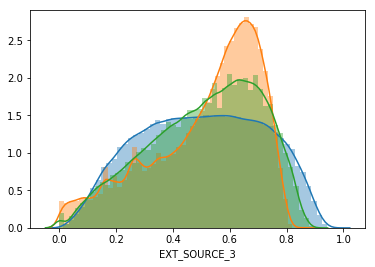

In [213]:
train['X_EXT_SOURCES_MEAN'] = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
sns.distplot(train['EXT_SOURCE_1'].dropna())
sns.distplot(train['EXT_SOURCE_2'].dropna())
sns.distplot(train['EXT_SOURCE_3'].dropna())
print(train.groupby(['OCCUPATION_TYPE']).X_EXT_SOURCES_MEAN.mean())
#print(train.groupby(['OCCUPATION_TYPE']).EXT_SOURCE_1.mean())

In [169]:
live = [_f for _f in train.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
live

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL']

In [64]:
feats.combine_categories(train)

In [157]:
    column = "ORGANIZATION_TYPE"
    agg = train.groupby(column).TARGET.agg(['mean', 'count'])
    agg['count'] = np.log(agg['count'])/np.log(2000)
    agg['count'] = np.where(agg['count'] < 1, 1, agg['count'])
    agg['mean'] = agg['mean'] * agg['count']
    train[column].map(agg['mean']).head()


0    0.136139
1    0.070759
2    0.084920
3    0.136139
4    0.058824
Name: ORGANIZATION_TYPE, dtype: float64

In [167]:
np.log(np.arange(1, 1000))/np.log(50)

array([0.        , 0.17718382, 0.28082971, 0.35436764, 0.41140809,
       0.45801353, 0.49741787, 0.53155146, 0.56165942, 0.58859191,
       0.61295531, 0.63519735, 0.65565805, 0.67460169, 0.6922378 ,
       0.70873528, 0.72423228, 0.73884324, 0.75266402, 0.76577573,
       0.77824758, 0.79013913, 0.80150199, 0.81238117, 0.82281618,
       0.83284187, 0.84248913, 0.85178551, 0.86075563, 0.86942162,
       0.87780343, 0.8859191 , 0.89378502, 0.9014161 , 0.90882596,
       0.91602706, 0.92303085, 0.92984784, 0.93648776, 0.94295955,
       0.94927153, 0.9554314 , 0.96144632, 0.96732295, 0.97306751,
       0.97868581, 0.98418327, 0.98956499, 0.99483574, 1.        ,
       1.00506199, 1.01002569, 1.01489483, 1.01967295, 1.0243634 ,
       1.02896933, 1.03349374, 1.03793945, 1.04230917, 1.04660544,
       1.0508307 , 1.05498725, 1.05907729, 1.06310292, 1.06706614,
       1.07096884, 1.07481286, 1.07859992, 1.0823317 , 1.08600978,
       1.08963569, 1.09321088, 1.09673676, 1.10021467, 1.10364

In [151]:
train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [117]:
(train['OCCUPATION_TYPE_NAME_EDUCATION_TYPE'].value_counts() >= 5000)

_Laborers_Secondary / secondary special                  True
_Sales staff_Secondary / secondary special               True
_Drivers_Secondary / secondary special                   True
_Core staff_Higher education                             True
_Core staff_Secondary / secondary special                True
_Managers_Higher education                               True
_Managers_Secondary / secondary special                  True
_Medicine staff_Secondary / secondary special            True
_Laborers_Higher education                               True
_High skill tech staff_Secondary / secondary special     True
_Accountants_Higher education                            True
_Security staff_Secondary / secondary special            True
_Sales staff_Higher education                            True
_Cooking staff_Secondary / secondary special             True
_High skill tech staff_Higher education                 False
_Cleaning staff_Secondary / secondary special           False
_Account

In [61]:
    # 変数の枠だけ作っておく
    categorical_feats = [
        f for f in train.columns if train[f].dtype == 'object'
    ]
categorical_feats

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

/home/arizuka/.pyenv/versions/3.6.4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


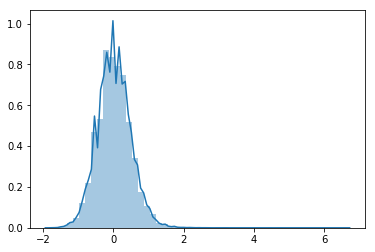

In [35]:
medians = train.groupby('ORGANIZATION_TYPE').AMT_INCOME_TOTAL.median()
ratio = train['AMT_INCOME_TOTAL'] / train.ORGANIZATION_TYPE.map(medians)
sns.distplot(np.log(ratio))

In [16]:
df = feats.app_stat_features(train, test)
df.rename(columns={ 'AMT_INCOME_TOTAL': 'HOGE' })

,OCCUPATION_TYPE,HOGE
0,Accountants,180000.0
1,Cleaning staff,117000.0
2,Cooking staff,135000.0
3,Core staff,157500.0
4,Drivers,180000.0
5,HR staff,162000.0
6,High skill tech staff,157500.0
7,IT staff,180000.0
8,Laborers,157500.0
9,Low-skill Laborers,126000.0


In [4]:
feats.app_features(train)
feats.app_features(test)

In [5]:
categorical_feats = [
    f for f in train.columns if train[f].dtype == 'object'
]
categorical_feats

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE']

In [6]:
for f in categorical_feats:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])

In [7]:
gc.enable()

In [8]:
y = train['TARGET']
del train['TARGET']

In [9]:
# prev_cat_features = [
#     f_ for f_ in prev.columns if prev[f_].dtype == 'object'
# ]
# for f_ in prev_cat_features:
#     prev[f_], _ = pd.factorize(prev[f_])

In [10]:
prev_refused = prev[prev['NAME_CONTRACT_STATUS'] == 'Refused']
prev = prev[prev['NAME_CONTRACT_STATUS'] == 'Approved']

In [11]:
prev['X_HOUR_APPR_PROCESS_START'] = prev['HOUR_APPR_PROCESS_START'].astype(str)
del prev['HOUR_APPR_PROCESS_START']

prev_cat_features = [
    f_ for f_ in prev.columns if prev[f_].dtype == 'object'
]
prev_dum = pd.DataFrame()
for f_ in prev_cat_features:
    prev_dum = pd.concat([prev_dum, pd.get_dummies(prev[f_], prefix=f_).astype(np.uint8)], axis=1)

prev = pd.concat([prev, prev_dum], axis=1)

del prev_dum
gc.collect()

91

In [12]:
avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
avg_prev['X_NB_APP'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']



In [13]:
cnt_prev_refused = prev_refused[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
cnt_prev_refused['X_REFUSED_CNT'] = cnt_prev_refused['SK_ID_PREV']
del cnt_prev_refused['SK_ID_PREV']

In [14]:
feats.prev_features(avg_prev)

In [15]:
buro_cat_features = [
    f_ for f_ in buro.columns if buro[f_].dtype == 'object'
]
buro_dum = pd.DataFrame()
for f_ in buro_cat_features:
    buro_dum = pd.concat([buro_dum, pd.get_dummies(buro[f_], prefix=f_).astype(np.uint8)], axis=1)

buro = pd.concat([buro, buro_dum], axis=1)

In [16]:
# buro_cat_features = [
#     f_ for f_ in buro.columns if buro[f_].dtype == 'object'
# ]
# for f_ in buro_cat_features:
#     buro[f_], _ = pd.factorize(buro[f_])

avg_buro = buro.groupby('SK_ID_CURR').mean()
avg_buro['X_BURO_COUNT'] = buro[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
del avg_buro['SK_ID_BUREAU']

In [17]:
pos = utils.read_csv('./input/POS_CASH_balance.csv')
pos = pd.concat([pos, pd.get_dummies(pos['NAME_CONTRACT_STATUS'])], axis=1)
nb_prevs = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pos['SK_ID_PREV'] = pos['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
avg_pos = pos.groupby('SK_ID_CURR').mean()

del pos, nb_prevs
gc.collect()

cc_bal = utils.read_csv('./input/credit_card_balance.csv')
cc_bal = pd.concat([cc_bal, pd.get_dummies(cc_bal['NAME_CONTRACT_STATUS'])], axis=1)

nb_prevs = cc_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
cc_bal['SK_ID_PREV'] = cc_bal['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

avg_cc_bal = cc_bal.groupby('SK_ID_CURR').mean()

del cc_bal, nb_prevs
gc.collect()

inst = utils.read_csv('./input/installments_payments.csv')
nb_prevs = inst[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
inst['SK_ID_PREV'] = inst['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

avg_inst = inst.groupby('SK_ID_CURR').mean()
del inst
gc.collect()

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


14

In [18]:
avg_prev.columns = ['prev_{}'.format(c) for c in avg_prev.columns]
avg_buro.columns = ['buro_{}'.format(c) for c in avg_buro.columns]
avg_inst.columns = ['inst_{}'.format(c) for c in avg_inst.columns]
avg_pos.columns = ['pos_{}'.format(c) for c in avg_pos.columns]
avg_cc_bal.columns = ['cc_bal_{}'.format(c) for c in avg_cc_bal.columns]

train = train.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
train = train.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
train = train.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
train = train.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
train = train.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
train = train.merge(right=cnt_prev_refused.reset_index(), how='left', on='SK_ID_CURR')

test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=cnt_prev_refused.reset_index(), how='left', on='SK_ID_CURR')

In [19]:
train['X_REFUSED_CNT'] = train['X_REFUSED_CNT'].fillna(0)
test['X_REFUSED_CNT'] = test['X_REFUSED_CNT'].fillna(0)

In [20]:
excluded_feats = ['SK_ID_CURR']
excluded_feats = sum(list(map(lambda c: [c, f"{c}_x", f"{c}_y"], excluded_feats)), [])
features = [f_ for f_ in train.columns if f_ not in excluded_feats]
features

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE'

In [21]:
# trn_x, val_x, trn_y, val_y = train_test_split(train[features], y,  test_size=0.2, random_state=42)

In [22]:
# params = {
#     'n_estimators': 4000,
#     'learning_rate': 0.01,
#     'num_leaves': 63,
#     'colsample_bytree': .8,
#     'subsample': .8,
#     'subsample_freq': 5,
#     'max_depth': 5,
#     'reg_alpha': .001,
#     'reg_lambda': .1,
#     'min_split_gain': .01,
#     'device': "gpu",
# #     'categorical_feature': 'name:CODE_GENDER'
# }


# clf = LGBMClassifier(**params)

# eval_set = [(trn_x, trn_y), (val_x, val_y)]

# %time clf.fit(trn_x, trn_y, eval_set=eval_set, eval_metric='auc', verbose=250, early_stopping_rounds=150)

# trn_preds = clf.predict_proba(trn_x, num_iteration=clf.best_iteration_)[:, 1]
# val_preds = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
# test_preds = clf.predict_proba(test[features], num_iteration=clf.best_iteration_)[:, 1]

# trn_auc = roc_auc_score(trn_y, trn_preds)
# auc = roc_auc_score(val_y, val_preds)
# print('AUC : %.6f' % auc)
# gc.collect()

# config = {
#     'model': 'lgbm',
#     'params': params,
#     'trn_auc': trn_auc,
#     'auc': auc,
#     'features': features
# }

In [23]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
trn_preds = np.zeros(train.shape[0])
oof_preds = np.zeros(train.shape[0])
test_preds = np.zeros(test.shape[0])

params = {
  'n_estimators': 4000,
  'learning_rate': 0.01,
  'num_leaves': 63,
  'colsample_bytree': .8,
  'subsample': .8,
  'subsample_freq': 5,
  'max_depth': 5,
  'reg_alpha': .001,
  'reg_lambda': .1,
  'min_split_gain': .01,
  'device': "gpu",
}
    

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(**params)
    clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='auc', verbose=250, early_stopping_rounds=150
           )
    

    trn_preds[trn_idx] = clf.predict_proba(trn_x, num_iteration=clf.best_iteration_)[:, 1]
    oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    test_preds += clf.predict_proba(test[features], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    val_auc = roc_auc_score(val_y, oof_preds[val_idx])
    print('Fold %2d AUC : %.6f' % (n_fold + 1, val_auc))
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()

clf=None
auc = roc_auc_score(y, oof_preds)
print('Full AUC score %.6f' % auc)
trn_auc = roc_auc_score(y, trn_preds)

config = {
    'model': 'lgbm',
    'params': params,
    'trn_auc': trn_auc,
    'auc': auc,
}

Training until validation scores don't improve for 150 rounds.
[250]	training's auc: 0.775715	valid_1's auc: 0.75575
[500]	training's auc: 0.797365	valid_1's auc: 0.769365
[750]	training's auc: 0.810005	valid_1's auc: 0.774892
[1000]	training's auc: 0.819601	valid_1's auc: 0.778202
[1250]	training's auc: 0.827856	valid_1's auc: 0.780409
[1500]	training's auc: 0.835001	valid_1's auc: 0.781886
[1750]	training's auc: 0.841768	valid_1's auc: 0.783067
[2000]	training's auc: 0.84808	valid_1's auc: 0.783921
[2250]	training's auc: 0.854174	valid_1's auc: 0.784368
[2500]	training's auc: 0.860099	valid_1's auc: 0.785053
[2750]	training's auc: 0.865304	valid_1's auc: 0.785536
[3000]	training's auc: 0.870441	valid_1's auc: 0.785753
[3250]	training's auc: 0.874972	valid_1's auc: 0.786027
Early stopping, best iteration is:
[3335]	training's auc: 0.876746	valid_1's auc: 0.786115
Fold  1 AUC : 0.786115
Training until validation scores don't improve for 150 rounds.
[250]	training's auc: 0.775261	valid_

In [24]:
# test_preds = np.zeros(test.shape[0])
# trn_aucs = []
# aucs = []
# random_states = [1, 42]

# for i in range(0, 2):
#     trn_x, val_x, trn_y, val_y = train_test_split(train[features], y,  test_size=0.2, random_state=random_states[i])
    
#     params = {
#       'n_estimators': 4000,
#       'learning_rate': 0.01,
#       'num_leaves': 63,
#       'colsample_bytree': .8,
#       'subsample': .8,
#       'subsample_freq': 5,
#       'max_depth': 5,
#       'reg_alpha': .001,
#       'reg_lambda': .1,
#       'min_split_gain': .01,
#       'device': "gpu",
#     }

#     clf = LGBMClassifier(**params)

#     eval_set = [(trn_x, trn_y), (val_x, val_y)]
#     %time clf.fit(trn_x, trn_y, eval_set=eval_set, eval_metric='auc', verbose=250, early_stopping_rounds=150)

#     trn_preds = clf.predict_proba(trn_x, num_iteration=clf.best_iteration_)[:, 1]
#     val_preds = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
#     test_preds += clf.predict_proba(test[features], num_iteration=clf.best_iteration_)[:, 1]

#     trn_auc = roc_auc_score(trn_y, trn_preds)
#     auc = roc_auc_score(val_y, val_preds)
#     print('Iter %d AUC : %.6f' % (i+1, auc))
#     trn_aucs.append(trn_auc)
#     aucs.append(auc)

#     del trn_x, val_x, trn_y, val_y
#     gc.collect()

# test_preds = test_preds/2
# trn_auc = np.array(trn_aucs).mean()
# auc = np.array(aucs).mean()
# print('AUC train_auc %.6f val_auc %.6f' % (trn_auc, auc))

# config = {
#     'model': 'lgbm',
#     'params': params,
#     'trn_auc': trn_auc,
#     'auc': auc,
# }

In [25]:
utils.save_result(
    test=test,
    test_preds=test_preds,
    config=config,
    features=features,
    clf=clf
)

Save to ./experiments/056-lgbm-0.786867.csv


In [26]:
reg = re.compile(r"(.*_)?X_")
handmade_features = [x for x in features if reg.match(x)]
for f in handmade_features:
    print('{}: {}'.format(f, clf.feature_importances_[features.index(f)]))


AttributeError: 'NoneType' object has no attribute 'feature_importances_'

In [ ]:
import lightgbm.plotting
lightgbm.plotting.plot_importance(clf, max_num_features=100, figsize=(20, 20))

In [1]:

import pandas as pd
import numpy as np


In [62]:
def weighted_average1(df, weight_col, by_col):
    print(weight_col)
    print(by_col)
    columns = [c for c in df.columns if df[c].dtype != 'object' and c not in [weight_col, by_col]]
    print(columns)

    wdf = pd.DataFrame({
        'c': df[by_col],
    })
    for c in columns:
        wdf[c] = df[c] * df[weight_col]
        wdf[f"{c}_notnull"] = df[weight_col] * pd.notnull(df[c])

    g = wdf.groupby(by_col).sum()
    print(g)

    c = 'b'
    print(g[c].sum() / g[f'{c}_notnull'].sum())
    
    avg = pd.DataFrame({})
    for c in columns:
        avg[c] = g[c] / g[f'{c}_notnull']
    return avg

In [66]:
def weighted_average2(data):
    d = {}
    weights = data['w']
    for c in data.columns:
        d[c] = np.average(data[c], weights=weights)
    return pd.Series(d)


df = pd.DataFrame({
    'c': [1, 1, 2, 2, 2],
    'a': [1, 2, 3, 4, 5],
    'b': [2, 2, 10, 5, 5],
    'w': [10, 0, 1, 1, 0],
})

# f = lambda x: np.average(x)
# df.groupby(['c']).apply(weighted_average)
weighted_average1(df, 'w', 'c')

w
c
['a', 'b']
    a  a_notnull   b  b_notnull
c                              
1  10         10  20         10
2   7          2  15          2
2.9166666666666665


,a,b
c,,
1,1.0,2.0
2,3.5,7.5


In [22]:
df = pd.DataFrame({
    'c': [1, 1, 2, 2, 2],
    'a': [1, 2, 3, 4, 5],
    'b': [2, 2, 10, 5, 5],
    'w': [10, 0, 1, 1, 0],
})

df[['c', 'a']] = df[['w', 'b']]
df['f'] = np.zeros(5)
df

,c,a,b,w,f
0,10,2,2,10,0.0
1,0,2,2,0,0.0
2,1,10,10,1,0.0
3,1,5,5,1,0.0
4,0,5,5,0,0.0


In [110]:
df = pd.DataFrame({
    'c': ['a', 'b', 'b', 'd'],
})
vals = df.c.value_counts()
df.loc[df.c.map(vals <= 1), 'c'] = 'None'
df

,c
0,None
1,b
2,b
3,None
